In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
from PIL import Image
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

from pathlib import Path

from pyproj import Transformer

from functools import partial
from collections import OrderedDict

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle

import time
import pickle

from icefunctions import plot_component_strength_map

In [3]:
n_components = 3

component_selected = 0

chip_size = 16

data_root = "saga_data"
n_channels = len(os.listdir(data_root)) // 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

L2_param = 1e-5

transformer = Transformer.from_crs("epsg:4326", "epsg:3413")

models_dir = 'res_comp/'
Path(models_dir).mkdir(parents=True, exist_ok=True)

train_max_epoch = 50

In [4]:
with open('components_analysis/mix_n{}.npy'.format(n_components), 'rb') as f:
    mix = np.load(f)

In [5]:
df = pd.read_csv('components_analysis/df_unique.csv', header=[0])
df['proj_x'], df['proj_y'] = transformer.transform(df.latitude,df.longitude)

In [6]:
df['latitude'].mean()

68.7847711764706

In [7]:
df.longitude.mean()

-133.49410438502673

In [5]:
for i in range(mix.shape[1]):
    df['component{}'.format(i)] = mix[:, i]

In [6]:
df.head()

,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,...,bottom_of_interval,month,year,month_cyclic,visible_ice_code,proj_x,proj_y,component0,component1,component2
0,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.85,1,NaN,Pure ice,ICE,Ice,...,1.4,3,2012,3,4,-2.280305e+06,-76170.639998,3.020992e+00,-3.513280e-01,1.557754e+00
1,69.16105,-133.08880,2012-03-21T00:00:00Z,0170-1-12,1.20,1,Nf,No visible ice,GP-GM,Coarse till,...,2.4,3,2012,3,0,-2.280371e+06,-76093.964428,-9.836304e-15,-2.845538e-14,-3.625484e-15
2,69.15849,-133.08865,2012-03-20T00:00:00Z,0170-1-17,1.45,1,NaN,No visible ice,SM-SC,Sand,...,2.3,3,2012,3,0,-2.280657e+06,-76109.484296,-5.746523e+00,5.205425e-02,6.007709e-01
3,69.15908,-133.08968,2012-03-20T00:00:00Z,0170-1-18,1.20,1,NaN,No visible ice,ML,Silt,...,2.3,3,2012,3,0,-2.280593e+06,-76066.285386,-5.746523e+00,5.205425e-02,6.007709e-01
4,69.15886,-133.09090,2012-03-21T00:00:00Z,0170-1-19,1.20,1,Nf,No visible ice,GP,Gravel,...,2.4,3,2012,3,0,-2.280619e+06,-76018.544396,-5.850486e+00,9.056090e-01,5.064118e-01


In [7]:
len(df)

561

## Cluster boreholes into groups

In [71]:
X = np.array(df[['latitude','longitude', ]])

In [92]:
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.01)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
#labels looks like [0, 0, 0, 1, 1, 1, 1, 2, 2,....]

cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 74


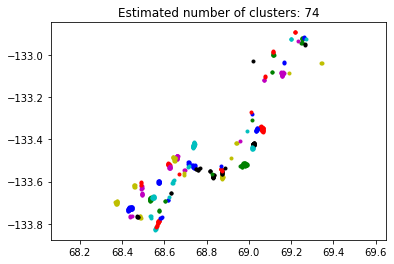

In [93]:
# #############################################################################
# Plot result
plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.axis('equal')
plt.show()

In [8]:
class SAGA10mDataset(Dataset):
    def __init__(self, data_root, df, mix, chip_size=32):
        
        self.df = df
        self.mix = mix
        
        # 1 pixel = 10|
        self.n_pixels = 10000
        self.base_y = -9995
        self.base_x = -239995
        
        self.chip_size = chip_size
        
        self.trans = transforms.ToTensor()
        
        self.n_channels = len(os.listdir(data_root))//2
        
        print("Dataset contains {} channels".format(self.n_channels))
        
        self.preloaded = torch.zeros(self.n_channels, self.n_pixels, self.n_pixels*2)
        
        file_list = os.listdir(data_root)
        
        for i in range(self.n_channels):
            # name = file.split('_')[0]
            # print(name)
            self.preloaded[i, :, 0:10000] = self.trans(Image.open(data_root + os.path.sep + file_list[i*2]))
            self.preloaded[i,:, 10000:20000] = self.trans(Image.open(data_root + os.path.sep + file_list[i*2 + 1]))
        
        self.preloaded[self.preloaded < -9000] = 0
        
        print('Dataset initialized')
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        
#         bh_id = row.at['borehole']
#         lat = row.at['latitude']
#         lng = row.at['longitude']
        
        x = row.at['proj_x']
        y = row.at['proj_y']
        
        
        pixel_len = 10
        
        
        
        x_start = max(0 , np.round((x - self.base_x) / pixel_len - self.chip_size/2).astype(int))
        x_end = min(20000, x_start + self.chip_size)
        
        y_start = max(0, np.round((- y) / pixel_len - self.chip_size/2).astype(int))
        y_end = min(20000, y_start + self.chip_size)
        

        image= self.preloaded[:, y_start:y_end, x_start:x_end]
        
        mix = torch.tensor(self.mix[idx]).float()
        
        return {'image': image, 'components_strengths': mix, \
                'latitude': row.at['latitude'], 'longitude': row.at['longitude'], 'borehole': row.at['borehole']}

In [9]:
full_dataset = SAGA10mDataset(data_root, df, mix, chip_size)

Dataset contains 1 channels


c:\users\mouju\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Dataset initialized


In [10]:
# check max min values

minval = 1000
maxval = 0

for i in range(len(full_dataset)):
    image = full_dataset[i]['image'].flatten()
    
    minval = min(minval, min(image))
    maxval = max(maxval, max(image))

print(minval)
print(maxval)

# normalize image values
magnitude_max = max(abs(minval), maxval)

for i in range(len(full_dataset)):
    full_dataset[i]['image'] = full_dataset[i]['image'] / magnitude_max
    

tensor(0.)
tensor(0.1342)


In [11]:
def train(trainloader, testloader, print_epochs = False, loss_fn = torch.nn.BCELoss()):
    
    model= models.resnet18()
    model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=n_components)
    
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), weight_decay = L2_param)

    epoch_loss = np.zeros([train_max_epoch, 2])
    for epoch in range(train_max_epoch):  # loop over the dataset multiple times

        model.train()
        running_loss_sum = 0.0
        for i, data in enumerate(trainloader, 0): # loop over each sample
            # get the inputs; data is a list of [inputs, labels]
            image, labels = data['image'].to(device), data['components_strengths'].to(device)

            predicted = model(image)
            
            
#             print(predicted.squeeze().get_device())
#             print('\n')
#             print(labels.get_device())
            
            
            # squeeze: return tensor with all dimensions of size 1 removed
            loss = loss_fn(predicted.squeeze(), labels)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss_sum += loss.item()

        # ----------- get validation loss for current epoch --------------
        model.eval()
        validation_loss_sum = 0.0
        for i, data in enumerate(testloader, 0): # loop over each sample

            image, labels = data['image'].to(device), data['components_strengths'].to(device)

            predicted = model(image)
            
            loss = loss_fn(predicted.squeeze(), labels)

            validation_loss_sum += loss.item()

        # ---------------- print statistics ------------------------

        running_loss = running_loss_sum / len(trainloader)
        validation_loss = validation_loss_sum / len(testloader)
        epoch_loss[epoch, :] =  [running_loss, validation_loss]
        
        if print_epochs:
            print('epoch %2d: running loss: %.5f, validation loss: %.5f' %
                          (epoch + 1, running_loss, validation_loss))
        
        torch.save(model.state_dict(), os.path.join(models_dir, 'epoch-{}.pt'.format(epoch+1)))
    
    if print_epochs:
        print('Finished Training')
        
    return epoch_loss
        
def test(epoch_loss, print_model_epoch = False):
    
    # ------ select model ---------
    ind = np.argmin(epoch_loss[:, 1])
    
    
    model= models.resnet18()
    model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=n_components)
    
    model.load_state_dict(torch.load('{}epoch-{}.pt'.format(models_dir, ind+1)))
    
    model.to(device)
    
    if print_model_epoch:
        print("epoch {} model selected".format(ind+1))
    
    # evaluate model on test set
    model.eval()

    with torch.no_grad():
        res_strengths = []
        
        for i, data in enumerate(testloader, 0):
            image, labels = data['image'].to(device), data['components_strengths'].to(device)
            # y_test.append(label.numpy().list())
            # print(label.shape)
            # print(images.shape)

            output = model(image)
            
            res_strengths.extend(output)
            
    return res_strengths

In [12]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# batchsize can cause error when last leftover batchsize is 1, batchnorm cannot function on 1 sample data
batchsize = 20
while(train_size % batchsize == 1):
    batchsize+=1
print(batchsize)

train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
testloader = DataLoader(test_data, batch_size=batchsize, shuffle=True)

20


In [13]:
len(trainloader)

23

In [14]:
test_length = len(test_data)

In [15]:
latitudes_map = np.zeros(test_length)
longitudes_map = np.zeros(test_length)
mix_map = np.zeros([test_length, n_components])
for i in range(test_length):
    data= test_data[i]
    latitudes_map[i] = data['latitude']
    longitudes_map[i] = data['longitude']
    mix_map[i] = data['components_strengths']

In [16]:
mix_map.shape

(113, 3)

In [17]:
for it in range(1):
    start = time.time()
    
    epoch_loss = train(trainloader,testloader, print_epochs = True, loss_fn = nn.HuberLoss())
    res_strengths= test(epoch_loss, print_model_epoch = True)

    end = time.time()
    
    print('iteration {} elapsed time: {}'.format(it+1, end-start))



c:\users\mouju\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch  1: running loss: 0.88054, validation loss: 1.21933
epoch  2: running loss: 0.69844, validation loss: 2.34231
epoch  3: running loss: 0.67683, validation loss: 0.77678
epoch  4: running loss: 0.65867, validation loss: 0.67998
epoch  5: running loss: 0.66646, validation loss: 0.73333
epoch  6: running loss: 0.64768, validation loss: 0.73970
epoch  7: running loss: 0.62871, validation loss: 0.67542
epoch  8: running loss: 0.63032, validation loss: 0.86701
epoch  9: running loss: 0.63718, validation loss: 0.82367
epoch 10: running loss: 0.62916, validation loss: 0.71723
epoch 11: running loss: 0.61227, validation loss: 0.72075
epoch 12: running loss: 0.59953, validation loss: 0.72075
epoch 13: running loss: 0.60655, validation loss: 0.64677
epoch 14: running loss: 0.57905, validation loss: 0.79052
epoch 15: running loss: 0.60187, validation loss: 0.83222
epoch 16: running loss: 0.58442, validation loss: 0.88556
epoch 17: running loss: 0.60725, validation loss: 0.83965
epoch 18: runn

In [18]:
with open('components_analysis/sources_n{}.npy'.format(n_components), 'rb') as f:
    sources = np.load(f)

with open('components_analysis/bh_observations.npy', 'rb') as f:
    bh_obs = np.load(f) # visible_ice class

In [19]:
mix.shape

(561, 3)

In [20]:
sources.shape

(10, 3)

In [21]:
ica_approximation = np.matmul(mix, sources.T)

In [22]:
ica_approximation.shape

(561, 10)

In [24]:
len(res_strengths)

113

In [28]:
res_strengths = torch.vstack(res_strengths)

TypeError: vstack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [31]:
res_strengths = res_strengths.cpu().detach().numpy()

In [26]:
# for i, row in enumerate(res_strengths):
#     res_strengths_array[i] = res_strengths[i].cpu().detatch().numpy() # copies from gpu to cpu, detaches from graph, removes gradient, numpy() converts to np array

# torch vstack/concatenate

In [32]:
err = ((res_strengths - mix_map).flatten())
np.mean(err * err)



1.9839320265037763

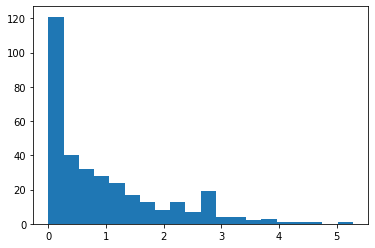

In [33]:
plt.hist(abs(err), bins=20)
plt.show()

In [34]:
np.amax(mix_map)

4.112119674682617

In [35]:
np.amin(mix_map)

-5.151512145996094

In [54]:
stacked_array = np.hstack((mix_map, res_strengths))

cols_a = ['ICA_{}'.format(i) for i in range(n_components)]
cols_b = ['Resnet_{}'.format(i) for i in range(n_components)]

cols = cols_a + cols_b

stacked_df = pd.DataFrame(stacked_array, columns = cols)

In [59]:
def component_coherence(i): 
    sb.lmplot(x='ICA_{}'.format(i), y='Resnet_{}'.format(i), data=stacked_df);
    plt.axis('equal')
# #     plt.scatter(mix_map[:, i], res_strengths[:, i])
    plt.savefig('components_analysis/component_coherence_n{}_channel{}.png'.format(n_components, i))
    plt.show()

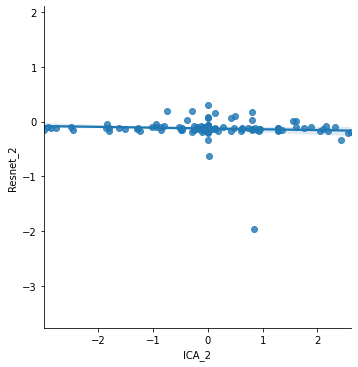

In [62]:
component_coherence(2)

In [ ]:
# for channel in range(3):
    
#     base = "components_analysis/components_strengths_{}_n{}_channel{}.html"
#     name_res = base.format("resnet", n_components, channel)
#     name_nonres = base.format("nonres", n_components, channel)
    
#     plot_component_strength_map(res_strengths[:, channel], channel, name_res, \
#                                 latitudes_map, longitudes_map)
    
#     plot_component_strength_map(mix_map[:, channel], channel, name_nonres, \
#                                 latitudes_map, longitudes_map)
    

In [ ]:
# n_max_bh = 50

# plt.figure()
# plt.subplot(311)
# plt.imshow(bh_obs[:, 0:n_max_bh], interpolation = 'none', extent=[0,n_max_bh-1, 5, 0])
# ax = plt.gca()
# ax.set_aspect(2)
# plt.colorbar()
# plt.title("Observed Visible Ice")
# plt.xlabel("Boreholes")
# plt.ylabel('Depth')

# plt.subplot(312)
# plt.imshow(ica_approximation[:, 0:n_max_bh], interpolation = 'none', extent=[0,n_max_bh-1, 5, 0])
# ax = plt.gca()
# ax.set_aspect(2)
# plt.colorbar()
# plt.title("ICA Approximation")
# plt.xlabel("Boreholes")
# plt.ylabel('Depth')

# plt.subplot(313)
# plt.imshow(res_approximation[:, 0:n_max_bh], interpolation = 'none', extent=[0,n_max_bh-1, 5, 0])
# ax = plt.gca()
# ax.set_aspect(2)
# plt.colorbar()
# plt.title("Resnet")
# plt.xlabel("Boreholes")
# plt.ylabel('Depth')

# # plt.savefig('components_analysis/comparison_n{}.png'.format(n_components))
# plt.show()